In [14]:
import torch as th
import numpy as np
import gymnasium as gym
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm

In [15]:
class PolicyNet(th.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        # 定义第一层全连接层，输入维度为状态维度，输出维度为隐藏层维度
        self.fc1 = th.nn.Linear(state_dim, hidden_dim)
        # 定义第二层全连接层，输入维度为隐藏层维度，输出维度为动作维度
        self.fc2 = th.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        # 使用ReLU作为激活函数
        x = F.relu(self.fc1(x))
        # 对第二层的输出使用softmax，得到一个概率分布
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(th.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        # 定义第一层全连接层，输入维度为状态维度，输出维度为隐藏层维度
        self.fc1 = th.nn.Linear(state_dim, hidden_dim)
        # 定义第二层全连接层，输入维度为隐藏层维度，输出维度为1，表示状态价值
        self.fc2 = th.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # 使用ReLU作为激活函数
        x = F.relu(self.fc1(x))
        # 第二层直接输出，代表状态的价值
        return self.fc2(x)

In [16]:
def compute_advantage(gamma, lambda_, td_delta):
    # 将td_delta从PyTorch张量转化为numpy数组
    td_delta = td_delta.detach().numpy()
    # 初始化优势值和优势列表
    advantage_list = []
    advantage = 0.0
    # 以逆序遍历td_delta中的每一个元素
    for delta in td_delta[::-1]:
        # 利用公式`advantage = gamma * lambda_ * advantage + delta`计算每个时间步的优势
        advantage = gamma * lambda_ * advantage + delta
        # 将优势添加到优势列表中
        advantage_list.append(advantage)
    # 将优势列表中的元素顺序反转
    advantage_list.reverse()
    # 将优势列表转化为PyTorch张量
    return th.tensor(advantage_list, dtype=th.float)

In [17]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lambda_, epochs, eps, gamma, device):
        # 初始化Actor网络和Critic网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        # 设置对应的优化器
        self.actor_optimizer = th.optim.Adam(self.actor.parameters(),
                                             lr=actor_lr)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters(),
                                              lr=critic_lr)
        # 设置强化学习的参数
        self.gamma = gamma
        self.lambda_ = lambda_
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device  # 设备选择（CPU or GPU）

    def take_action(self, state):
        # 通过Actor网络获取动作的概率分布
        state = th.tensor(np.array([state]), dtype=th.float).to(self.device)
        probs = self.actor(state)
        # 从动作的概率分布中采样一个动作
        action_dist = th.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        # 获取转换的状态、动作、奖励、下一状态和结束标志
        states = th.tensor(transition_dict["states"], dtype=th.float).to(self.device)
        actions = th.tensor(transition_dict["actions"]).view(-1, 1).to(self.device)
        rewards = th.tensor(transition_dict["rewards"], dtype=th.float).view(-1, 1).to(self.device)
        next_states = th.tensor(transition_dict["next_states"], dtype=th.float).to(self.device)
        dones = th.tensor(transition_dict["dones"], dtype=th.float).view(-1, 1).to(self.device)

        # 计算TD目标和TD误差
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)

        # 计算优势函数
        advantage = compute_advantage(self.gamma, self.lambda_, td_delta.cpu()).to(self.device)
        old_log_probs = th.log(self.actor(states).gather(1, actions)).detach()

        # 进行多轮的网络更新
        for _ in range(self.epochs):
            # 计算新的动作概率
            log_probs = th.log(self.actor(states).gather(1, actions))
            ratio = th.exp(log_probs - old_log_probs)

            # 计算PPO的两种Surrogate函数
            surr1 = ratio * advantage
            surr2 = th.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断

            # 计算Actor和Critic的损失
            actor_loss = th.mean(-th.min(surr1, surr2))  # PPO损失函数
            critic_loss = th.mean(F.mse_loss(self.critic(states), td_target.detach()))

            # 清空优化器的梯度
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()

            # 反向传播损失，并执行一步优化
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [18]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []  # 用于存储每个周期的总回报
    for i in range(10):  # 总共进行10次迭代
        with tqdm(total=int(num_episodes / 10), desc=f"Iteration: {i}") as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 在每个迭代周期中，智能体都会进行num_episodes / 10次动作
                episode_return = 0  # 用于存储每个周期的总回报
                transition_dict = {"states": [], "actions": [], "next_states": [], "rewards": [], "dones": []}  # 用于存储每个周期中的状态，动作和奖励等信息
                state, _ = env.reset()  # 重置环境，并获取初始状态
                done = False
                while not done:  # 在每个周期中，只要环境没有结束，智能体就会一直执行动作
                    action = agent.take_action(state)  # 通过当前策略选择动作
                    next_state, reward, done, _, _ = env.step(action)  # 执行动作，并获取下一状态，奖励和是否结束等信息
                    transition_dict["states"].append(state)  # 存储状态信息
                    transition_dict["actions"].append(action)  # 存储动作信息
                    transition_dict["next_states"].append(next_state)  # 存储下一状态信息
                    transition_dict["rewards"].append(reward)  # 存储奖励信息
                    transition_dict["dones"].append(done)  # 存储是否结束信息
                    state = next_state  # 更新状态
                    episode_return += reward  # 更新总回报
                return_list.append(episode_return)  # 存储该周期的总回报
                agent.update(transition_dict)  # 通过学习这个周期的状态，动作和奖励等信息更新策略
                if (i_episode + 1) % 10 == 0:  # 每10个周期，输出一次信息
                    pbar.set_postfix({"episode": "%d" % (num_episodes / 10 * i + i_episode + 1),  # 输出当前的周期数
                                      "return": "%.3f" % np.mean(return_list[-10:])})  # 输出最近10个周期的平均总回报
                pbar.update(1)  # 更新进度条
    return return_list  # 返回所有周期的总回报

In [19]:
actor_lr = 1e-3  # Actor的学习率
critic_lr = 1e-2  # Critic的学习率
num_episodes = 300  # 总的周期数
hidden_dim = 128  # 隐藏层的维度
gamma = 0.98  # 折扣因子
lambda_ = 0.95  # PPO的参数
epochs = 5  # PPO的参数
eps = 0.2  # PPO的参数
device = th.device("cuda" if th.cuda.is_available() else "cpu")  # 使用的设备

env_name = "CartPole-v1"    # 环境名称
env = gym.make(env_name)    # 创建环境
state_dim = env.observation_space.shape[0]  # 状态的维度
action_dim = env.action_space.n             # 动作的维度
# 实例化智能体
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma, device)

In [20]:
return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration: 9: 100%|██████████| 30/30 [18:20<00:00, 36.67s/it, episode=300, return=153866.500]


In [26]:
return_list

[16.0,
 43.0,
 18.0,
 55.0,
 25.0,
 25.0,
 42.0,
 30.0,
 36.0,
 14.0,
 35.0,
 99.0,
 62.0,
 37.0,
 28.0,
 67.0,
 21.0,
 51.0,
 21.0,
 60.0,
 53.0,
 84.0,
 39.0,
 26.0,
 64.0,
 50.0,
 93.0,
 108.0,
 36.0,
 56.0,
 32.0,
 62.0,
 62.0,
 55.0,
 87.0,
 87.0,
 71.0,
 57.0,
 102.0,
 68.0,
 102.0,
 76.0,
 80.0,
 33.0,
 60.0,
 54.0,
 48.0,
 90.0,
 62.0,
 154.0,
 271.0,
 199.0,
 211.0,
 181.0,
 155.0,
 209.0,
 220.0,
 194.0,
 176.0,
 133.0,
 238.0,
 210.0,
 189.0,
 166.0,
 491.0,
 161.0,
 72.0,
 310.0,
 220.0,
 244.0,
 368.0,
 467.0,
 249.0,
 435.0,
 281.0,
 382.0,
 76.0,
 148.0,
 200.0,
 202.0,
 382.0,
 168.0,
 122.0,
 172.0,
 360.0,
 300.0,
 349.0,
 242.0,
 300.0,
 189.0,
 398.0,
 620.0,
 512.0,
 313.0,
 314.0,
 380.0,
 367.0,
 439.0,
 205.0,
 221.0,
 912.0,
 668.0,
 446.0,
 285.0,
 346.0,
 302.0,
 657.0,
 123.0,
 588.0,
 519.0,
 243.0,
 582.0,
 342.0,
 414.0,
 244.0,
 217.0,
 413.0,
 276.0,
 371.0,
 585.0,
 242.0,
 296.0,
 460.0,
 348.0,
 198.0,
 483.0,
 1612.0,
 381.0,
 928.0,
 447.0,
 1083.0

In [24]:
def moving_average(a, window_size):
    # 计算累积和，np.insert用于在数组第一个位置插入0
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    # 计算每个窗口的平均值
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    # 为了处理开始和结束位置不足窗口大小的部分，独立计算它们的平均值
    # np.arange(1, window_size - 1, 2) 创建一个从1开始，到window_size - 1为止，步长为2的等差数组
    # np.cumsum(a[:window_size - 1])[::2] / r 计算的是开始位置的平均值
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    # np.cumsum(a[:-window_size:-1])[::2] / r 计算的是结束位置的平均值
    # [::-1] 是为了将结果翻转，因为我们是从后向前计算的
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    # 将开始、中间和结束的部分连接起来，得到最终的滑动平均值
    return np.concatenate((begin, middle, end))

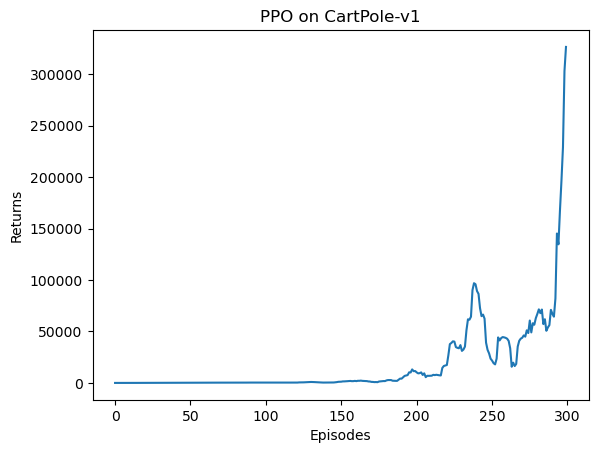

In [27]:
episodes_list = list(range(len(return_list)))
mv_return_list = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return_list)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title(f"PPO on {env_name}")
plt.show()